In [2]:
print(__doc__)

import seaborn as sns

sns.set_context("poster")

Automatically created module for IPython interactive environment


In [3]:
import numpy as np
from sklearn.datasets import fetch_lfw_people

data = fetch_lfw_people()
george_bush_id = 1871  # Photos of George W. Bush
bill_clinton_id = 531  # Photos of Bill Clinton
classes = [george_bush_id, bill_clinton_id]
classes_name = np.array(["B. Clinton", "G.W. Bush"], dtype=object)

In [4]:
mask_photos = np.isin(data.target, classes)
X, y = data.data[mask_photos], data.target[mask_photos]
y = (y == george_bush_id).astype(np.int8)
y = classes_name[y]

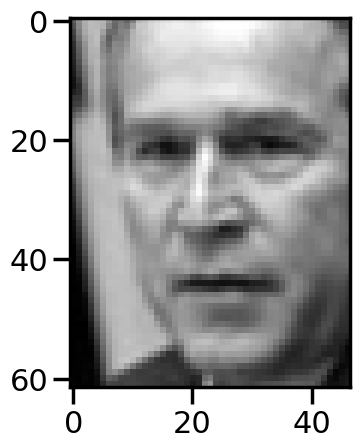

In [15]:
plt.imshow(X[0].reshape(62, 47), cmap="gray")

The positive label considered as the minority class is B. Clinton


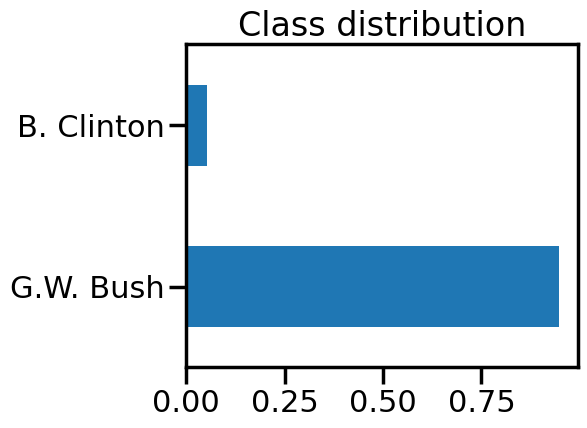

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

class_distribution = pd.Series(y).value_counts(normalize=True)
ax = class_distribution.plot.barh()
ax.set_title("Class distribution")
pos_label = class_distribution.idxmin()
plt.tight_layout()
print(f"The positive label considered as the minority class is {pos_label}")

In [7]:
from sklearn.neighbors import KNeighborsClassifier

from imblearn import FunctionSampler
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.pipeline import make_pipeline

classifier = KNeighborsClassifier(n_neighbors=3)

pipeline = [
    make_pipeline(FunctionSampler(), classifier),
    make_pipeline(RandomOverSampler(random_state=42), classifier),
    make_pipeline(ADASYN(random_state=42), classifier),
    make_pipeline(SMOTE(random_state=42), classifier),
]

(559, 2914)
(1062, 2914)


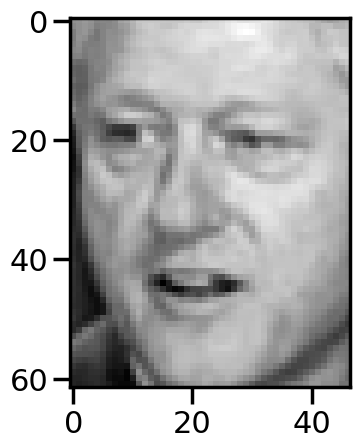

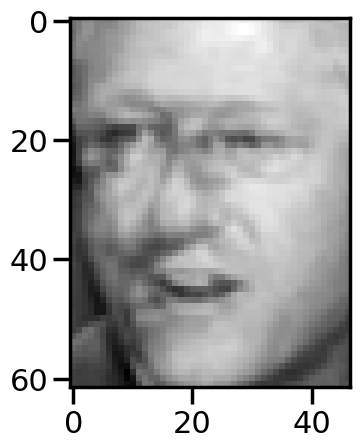

In [26]:
adasyn = ADASYN(random_state=42)
x_res, y_res = adasyn.fit_resample(X, y)
print(X.shape)
print(x_res.shape)
plt.imshow(x_res[1].reshape(62, 47), cmap="gray")
plt.show()
plt.imshow(x_res[560].reshape(62, 47), cmap="gray")
plt.show()

In [8]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=3)

In [9]:
from sklearn.metrics import RocCurveDisplay, auc, roc_curve

disp = []
for model in pipeline:
    # compute the mean fpr/tpr to get the mean ROC curve
    mean_tpr, mean_fpr = 0.0, np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        model.fit(X[train], y[train])
        y_proba = model.predict_proba(X[test])

        pos_label_idx = np.flatnonzero(model.classes_ == pos_label)[0]
        fpr, tpr, thresholds = roc_curve(
            y[test], y_proba[:, pos_label_idx], pos_label=pos_label
        )
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0

    mean_tpr /= cv.get_n_splits(X, y)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    # Create a display that we will reuse to make the aggregated plots for
    # all methods
    disp.append(
        RocCurveDisplay(
            fpr=mean_fpr,
            tpr=mean_tpr,
            roc_auc=mean_auc,
            estimator_name=f"{model[0].__class__.__name__}",
        )
    )

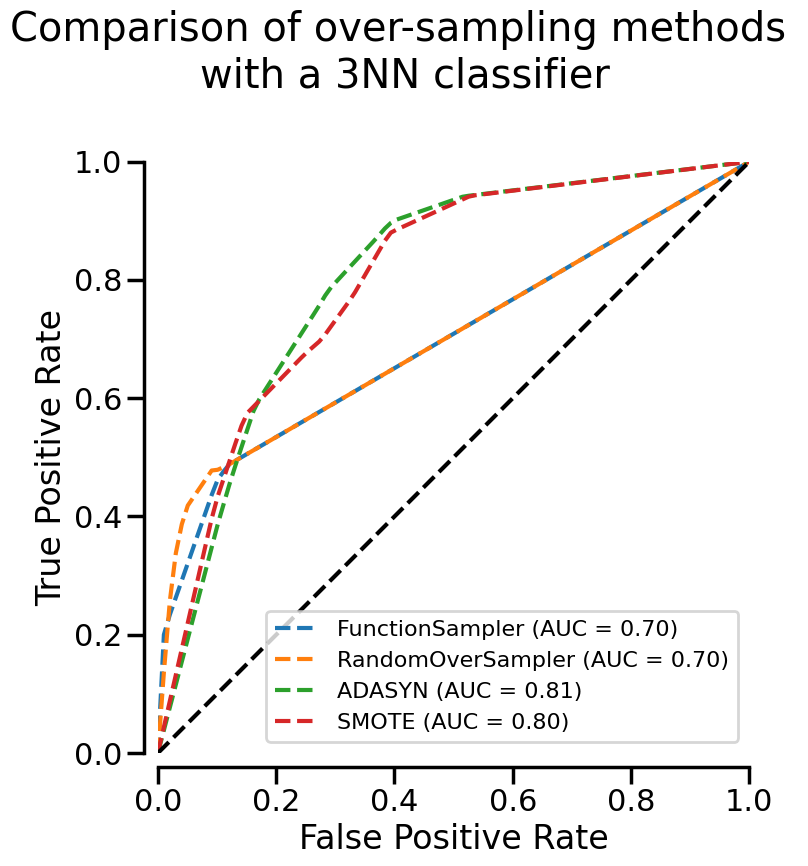

In [10]:
fig, ax = plt.subplots(figsize=(9, 9))
for d in disp:
    d.plot(ax=ax, linestyle="--")
ax.plot([0, 1], [0, 1], linestyle="--", color="k")
ax.axis("square")
fig.suptitle("Comparison of over-sampling methods \nwith a 3NN classifier")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
sns.despine(offset=10, ax=ax)
plt.legend(loc="lower right", fontsize=16)
plt.tight_layout()
plt.show()